# Installing BIGGAN

In [1]:
imagenet_path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/imagenet"
path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/"

In [ ]:
!pip install pytorch-pretrained-biggan


# import packages

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import glob
import scipy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.stats import truncnorm

import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import PIL 
import pickle 
from tqdm import tqdm

from PIL import Image

import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using the GPU!


# Utilities

In [3]:

def rgb_to_lab(srgb):

	srgb_pixels = torch.reshape(srgb, [-1, 3])

	linear_mask = (srgb_pixels <= 0.04045).type(torch.FloatTensor).cuda()
	exponential_mask = (srgb_pixels > 0.04045).type(torch.FloatTensor).cuda()
	rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
	
	rgb_to_xyz = torch.tensor([
				#    X        Y          Z
				[0.412453, 0.212671, 0.019334], # R
				[0.357580, 0.715160, 0.119193], # G
				[0.180423, 0.072169, 0.950227], # B
			]).type(torch.FloatTensor).cuda()
	
	xyz_pixels = torch.mm(rgb_pixels, rgb_to_xyz)
	

	# XYZ to Lab
	xyz_normalized_pixels = torch.mul(xyz_pixels, torch.tensor([1/0.950456, 1.0, 1/1.088754]).type(torch.FloatTensor).cuda())

	epsilon = 6.0/29.0

	linear_mask = (xyz_normalized_pixels <= (epsilon**3)).type(torch.FloatTensor).cuda()

	exponential_mask = (xyz_normalized_pixels > (epsilon**3)).type(torch.FloatTensor).cuda()

	fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4.0/29.0) * linear_mask + ((xyz_normalized_pixels+0.000001) ** (1.0/3.0)) * exponential_mask
	# convert to lab
	fxfyfz_to_lab = torch.tensor([
		#  l       a       b
		[  0.0,  500.0,    0.0], # fx
		[116.0, -500.0,  200.0], # fy
		[  0.0,    0.0, -200.0], # fz
	]).type(torch.FloatTensor).cuda()
	lab_pixels = torch.mm(fxfyfz_pixels, fxfyfz_to_lab) + torch.tensor([-16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda()
	#return tf.reshape(lab_pixels, tf.shape(srgb))
	return torch.reshape(lab_pixels, srgb.shape)


In [4]:
def lab_to_rgb(lab):
		lab_pixels = torch.reshape(lab, [-1, 3])
		# convert to fxfyfz
		lab_to_fxfyfz = torch.tensor([
			#   fx      fy        fz
			[1/116.0, 1/116.0,  1/116.0], # l
			[1/500.0,     0.0,      0.0], # a
			[    0.0,     0.0, -1/200.0], # b
		]).type(torch.FloatTensor).cuda()
		fxfyfz_pixels = torch.mm(lab_pixels + torch.tensor([16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda(), lab_to_fxfyfz)

		# convert to xyz
		epsilon = 6.0/29.0
		linear_mask = (fxfyfz_pixels <= epsilon).type(torch.FloatTensor).cuda()
		exponential_mask = (fxfyfz_pixels > epsilon).type(torch.FloatTensor).cuda()


		xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29.0)) * linear_mask + ((fxfyfz_pixels+0.000001) ** 3) * exponential_mask

		# denormalize for D65 white point
		xyz_pixels = torch.mul(xyz_pixels, torch.tensor([0.950456, 1.0, 1.088754]).type(torch.FloatTensor).cuda())


		xyz_to_rgb = torch.tensor([
			#     r           g          b
			[ 3.2404542, -0.9692660,  0.0556434], # x
			[-1.5371385,  1.8760108, -0.2040259], # y
			[-0.4985314,  0.0415560,  1.0572252], # z
		]).type(torch.FloatTensor).cuda()

		rgb_pixels =  torch.mm(xyz_pixels, xyz_to_rgb)
		# avoid a slightly negative number messing up the conversion
		#clip
		rgb_pixels[rgb_pixels > 1] = 1
		rgb_pixels[rgb_pixels < 0] = 0

		linear_mask = (rgb_pixels <= 0.0031308).type(torch.FloatTensor).cuda()
		exponential_mask = (rgb_pixels > 0.0031308).type(torch.FloatTensor).cuda()
		srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + (((rgb_pixels+0.000001) ** (1/2.4) * 1.055) - 0.055) * exponential_mask
	
		return torch.reshape(srgb_pixels, lab.shape)


# Dataset (Imagenet)

In [ ]:

%mkdir imagenet 
%cd imagenet 
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/CV/project/ILSVRC2012_img_val.tar"
%cd /content



In [5]:
class INColorDataset(Dataset):
    def __init__(self, subset, fig_size, split, transform=None):

        all_imgs = sorted(glob.glob("/content/imagenet/*"))
        labels = []
        with open(path_drive + "val_gt.txt") as f:
            for line in f:
                labels += [int(line)]

        self.map = self.get_map()

        if(subset == "5k"):
            all_imgs = all_imgs[:5000]
            labels = labels[:5000]
        elif(subset == "10k"):
            all_imgs = all_imgs[:10000]
            labels = labels[:10000]

        all_imgs_size = len(all_imgs)
        if(split == "train"):
            self.imgs = all_imgs[:int(0.6 * all_imgs_size)]
            self.labels = labels[:int(0.6 * all_imgs_size)]
            
        elif(split == "val"):
            self.imgs = all_imgs[int(0.6 * all_imgs_size) : int(0.8 * all_imgs_size)]
            self.labels = labels[int(0.6 * all_imgs_size) : int(0.8 * all_imgs_size)]
        else:
            self.imgs = all_imgs[int(0.8 * all_imgs_size) : ]
            self.labels = labels[int(0.8 * all_imgs_size) : ]
        
        self.transform = transform
        self.fig_size = fig_size

    def __len__(self):
        return len(self.imgs)

    def get_map(self):
        metadata = scipy.io.loadmat(path_drive + "meta.mat",struct_as_record=False)
        synsets = np.squeeze(metadata['synsets'])
        map = {s.ILSVRC2012_ID[0][0] : s.words[0].split(",")[0] for s in synsets[:1000]}
        return map

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path)

        img = img.convert("RGB")


        color_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.fig_size, self.fig_size))                                   
        ])

        gray_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.fig_size, self.fig_size)),
                transforms.Grayscale(num_output_channels=3)                            
        ])

        label = self.labels[idx]

        label = one_hot_from_names([self.map[label]],batch_size=1).argmax()


        color = color_trans(img)
        gray = gray_trans(img)


        return gray, color, label

In [6]:
def get_dataloader(subset, img_size, split, batch_size=32, num_workers=4):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    
    dataset = INColorDataset(subset, img_size, split)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(split == "train"),
        num_workers=num_workers,

    )
    return dataloader



# Model


In [7]:
class ColorNet(nn.Module):


    def __init__(self, z_dim = 128, out_size = 128):
        super().__init__()

        
        """
        resnet: 2048
        eff: 2560
        """

        self.encoder = self.encoder_setup(name="resnet")
        self.classifier = self.classifier_setup(name="efficient")

        '''
        FC layers mapping from 2048 (output of encoder) to lower dim for BIGGAN
        '''
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 128)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(128)

        self.gan = BigGAN.from_pretrained(f'biggan-deep-{out_size}')

        
    def encoder_setup(self, name="resnet"):

        '''
        pretrained resnet used to encode images to lower dim representation
        '''
        model = None
        if(name == "resnet"):
            model = torchvision.models.resnet50(pretrained=True)
        elif(name == "efficient"):
            model = torchvision.models.efficientnet_b7(pretrained=True)

        model = torch.nn.Sequential(*(list(model.children())[:-1]))

        return model

    def classifier_setup(self, name="resnet"):
        '''
        BIGGAN also takes class prediction so I use
        another resnet to output class probabilities
        '''
        model = None
        if(name == "resnet"):
            model = torchvision.models.resnet50(pretrained=True)
        elif(name == "efficient"):
            model = torchvision.models.efficientnet_b7(pretrained=True)
        return model

    def forward(self, x, gt=None, truncation=1):
        x = transforms.Normalize(mean=[0.445, 0.445, 0.445],
                                 std=[0.269, 0.269, 0.269])(x)

        probs = self.classifier(x)
        labels = None

        if(gt == None):
          ##one hot the max label
          labels = torch.argmax(probs, dim=1)
          labels = F.one_hot(labels, num_classes=1000).type(torch.float32)
        else:
          labels = F.one_hot(gt, num_classes=1000).type(torch.float32)


        encoding = self.encoder(x)
        
        encoding = nn.Flatten()(encoding)

        encoding = self.fc1(encoding)
        encoding = self.bn1(encoding)
        encoding = F.relu(encoding)
        encoding = self.fc2(encoding)
        encoding = self.bn2(encoding)


        encoding = encoding * truncation
        '''
        gan takes three arguments: encoding, class probs, and truncation factor (set to 1 here for no truncation)
        '''
        output = self.gan(encoding, labels, 1)

        '''
        outputs of BIGGAN images are scaled in [-1, 1], so scale it back to [0,1]
        '''
        norm_output = (output + 1) / 2
        return norm_output, encoding, labels
        

In [8]:
'''
Only train encoder and classifier parameters
'''

colornet = ColorNet().to(device)
# colornet.load_state_dict(torch.load(path_drive + "best_model_biggan_onehot.pt"))


# for param in colornet.gan.parameters():
#     param.requires_grad = False


trainables = []
trainables.extend(colornet.encoder.parameters())
trainables.extend(colornet.fc1.parameters())
trainables.extend(colornet.fc2.parameters())
trainables.extend(colornet.bn1.parameters())
trainables.extend(colornet.bn2.parameters())

In [9]:

'''
Adam optimizer
'''

optimizer = torch.optim.Adam(trainables, lr = 0.001, betas = (0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.1)
truncation = 1

In [10]:
def evaluate(model, dataloader):
    running_loss = 0

    model.eval()
    with torch.no_grad():
        for g, c, gt in dataloader:
            # check your input and target, these should be zero-mean one-std
            g = g.to(device)
            c = c.to(device)
            gt = gt.to(device)
            # c = rgb_to_lab(c)

            out, _, _ = model(g, gt=gt)

            # #change out to LAB
            # out_lab = rgb_to_lab(out)

            # #normalize all LAB readings and retreive colors
            # c_colors = c[:, 1:, :, :] / 100
            # out_lab_colors = out_lab[:, 1:, :, :] / 100

            loss = nn.MSELoss()(out, c)
            
            # statistics
            running_loss += loss.item() * g.size(0)

    print('Evaluation Loss: {:.4f}'.format(running_loss / len(dataloader.dataset)))
    return running_loss / len(dataloader.dataset)

In [11]:
'''
standard training loop
'''
def train_model(model, dataloaders, optimizer, scheduler, num_epochs=10):
    best_val_loss = 100000
    train_losses, val_losses = [], []


    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        running_loss = 0
        batches = tqdm(dataloaders["train"], total=len(dataloaders["train"]))

        for g, c, gt in batches:
            # check your input and target, these should be zero-mean one-std
            g = g.to(device)
            c = c.to(device)
            gt = gt.to(device)
            # c = rgb_to_lab(c)

            # zero the parameter gradients
            optimizer.zero_grad()

            out, _, _ = model(g, gt=gt)

            # #change out to LAB
            # out_lab = rgb_to_lab(out)

            # #normalize all LAB readings and retreive colors
            # c_colors = c[:, 1:, :, :] / 100
            # out_lab_colors = out_lab[:, 1:, :, :] / 100

            loss = nn.MSELoss()(out, c)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * g.size(0)

            batches.set_description(
              "Current Loss ({:.4e}), running total ({:.4e}) ".format(
                   loss.item(), running_loss
              )
            ) 
        if(scheduler is not None):
            scheduler.step()
        
        epoch_loss = running_loss / len(dataloaders["train"].dataset)
        print('Epoch Loss: {:.4f}'.format(epoch_loss))
        train_losses.append(epoch_loss)

        # evaluate loss on val
        val_loss = evaluate(model, dataloaders["val"])
        val_losses.append(val_loss)

        if(val_loss < best_val_loss):
            print('\n Saving this model: \n')
            best_val_loss = val_loss
            torch.save(model.state_dict(), path_drive + "gt.pt")

    
    return model, train_losses, val_losses

In [12]:
dls = {split : get_dataloader("5k", 128, split) for split in ["train", "val", "test"]}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:

colornet, train_losses, val_losses = train_model(colornet, dls, optimizer, None, num_epochs = 50)
pickle.dump(train_losses, open(path_drive + "gt_train_losses.pkl", 'wb'))
pickle.dump(val_losses, open(path_drive + "gt_val_losses.pkl", 'wb'))

Epoch 1/50
----------


  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Current Loss (8.7762e-02), running total (2.8220e+02) : 100%|██████████| 94/94 [01:09<00:00,  1.36it/s]


Epoch Loss: 0.0941
Evaluation Loss: 0.1187

 Saving this model: 

Epoch 2/50
----------


Current Loss (8.4576e-02), running total (2.4700e+02) : 100%|██████████| 94/94 [01:06<00:00,  1.41it/s]

Epoch Loss: 0.0823


Evaluation Loss: nan
Epoch 3/50
----------


Current Loss (8.2040e-02), running total (2.2543e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

Epoch Loss: 0.0751


Evaluation Loss: 0.0684

 Saving this model: 

Epoch 4/50
----------


Current Loss (7.1414e-02), running total (2.0467e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0682


Evaluation Loss: 0.0790
Epoch 5/50
----------


Current Loss (6.5242e-02), running total (1.9817e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

Epoch Loss: 0.0661


Evaluation Loss: 0.0624

 Saving this model: 

Epoch 6/50
----------


Current Loss (5.3513e-02), running total (1.8591e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


Epoch Loss: 0.0620
Evaluation Loss: 0.0623

 Saving this model: 

Epoch 7/50
----------


Current Loss (5.6762e-02), running total (1.7978e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0599


Evaluation Loss: 0.0589

 Saving this model: 

Epoch 8/50
----------


Current Loss (7.3490e-02), running total (1.7622e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


Epoch Loss: 0.0587
Evaluation Loss: 0.0579

 Saving this model: 

Epoch 9/50
----------


Current Loss (5.7138e-02), running total (1.7192e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]

Epoch Loss: 0.0573


Evaluation Loss: 0.0567

 Saving this model: 

Epoch 10/50
----------


Current Loss (6.0137e-02), running total (1.6787e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]

Epoch Loss: 0.0560


Evaluation Loss: 0.0546

 Saving this model: 

Epoch 11/50
----------


Current Loss (6.5643e-02), running total (1.6475e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0549


Evaluation Loss: 0.0535

 Saving this model: 

Epoch 12/50
----------


Current Loss (6.0394e-02), running total (1.6199e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]


Epoch Loss: 0.0540
Evaluation Loss: 0.0533

 Saving this model: 

Epoch 13/50
----------


Current Loss (5.8442e-02), running total (1.5918e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


Epoch Loss: 0.0531
Evaluation Loss: 0.0552
Epoch 14/50
----------


Current Loss (5.2317e-02), running total (1.5766e+02) : 100%|██████████| 94/94 [01:03<00:00,  1.47it/s]

Epoch Loss: 0.0526


Evaluation Loss: 0.0511

 Saving this model: 

Epoch 15/50
----------


Current Loss (5.0449e-02), running total (1.5506e+02) : 100%|██████████| 94/94 [01:10<00:00,  1.34it/s]


Epoch Loss: 0.0517
Evaluation Loss: 0.0503

 Saving this model: 

Epoch 16/50
----------


Current Loss (5.5050e-02), running total (1.5267e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.43it/s]

Epoch Loss: 0.0509


Evaluation Loss: 0.0505
Epoch 17/50
----------


Current Loss (5.3735e-02), running total (1.5138e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]


Epoch Loss: 0.0505
Evaluation Loss: 0.0501

 Saving this model: 

Epoch 18/50
----------


Current Loss (5.1388e-02), running total (1.5119e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]

Epoch Loss: 0.0504


Evaluation Loss: 0.0492

 Saving this model: 

Epoch 19/50
----------


Current Loss (5.0796e-02), running total (1.4915e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

Epoch Loss: 0.0497


Evaluation Loss: 0.0494
Epoch 20/50
----------


Current Loss (4.8540e-02), running total (1.4755e+02) : 100%|██████████| 94/94 [01:03<00:00,  1.47it/s]

Epoch Loss: 0.0492


Evaluation Loss: 0.0483

 Saving this model: 

Epoch 21/50
----------


Current Loss (5.2871e-02), running total (1.4757e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0492


Evaluation Loss: 0.0498
Epoch 22/50
----------


Current Loss (4.7697e-02), running total (1.4689e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]

Epoch Loss: 0.0490


Evaluation Loss: 0.0482

 Saving this model: 

Epoch 23/50
----------


Current Loss (5.1164e-02), running total (1.4477e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0483


Evaluation Loss: 0.0475

 Saving this model: 

Epoch 24/50
----------


Current Loss (4.7111e-02), running total (1.4437e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


Epoch Loss: 0.0481
Evaluation Loss: 0.0476
Epoch 25/50
----------


Current Loss (5.1319e-02), running total (1.4415e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]


Epoch Loss: 0.0480
Evaluation Loss: 0.0482
Epoch 26/50
----------


Current Loss (4.8552e-02), running total (1.4299e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

Epoch Loss: 0.0477


Evaluation Loss: 0.0473

 Saving this model: 

Epoch 27/50
----------


Current Loss (5.4211e-02), running total (1.4301e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]


Epoch Loss: 0.0477
Evaluation Loss: 0.0480
Epoch 28/50
----------


Current Loss (5.0953e-02), running total (1.4151e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]


Epoch Loss: 0.0472
Evaluation Loss: 0.0481
Epoch 29/50
----------


Current Loss (4.6523e-02), running total (1.4158e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]

Epoch Loss: 0.0472


Evaluation Loss: 0.0466

 Saving this model: 

Epoch 30/50
----------


Current Loss (4.5841e-02), running total (1.3989e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]

Epoch Loss: 0.0466


Evaluation Loss: 0.0468
Epoch 31/50
----------


Current Loss (4.2105e-02), running total (1.3978e+02) : 100%|██████████| 94/94 [01:03<00:00,  1.47it/s]

Epoch Loss: 0.0466


Evaluation Loss: 0.0468
Epoch 32/50
----------


Current Loss (4.7624e-02), running total (1.4134e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]


Epoch Loss: 0.0471
Evaluation Loss: 0.0528
Epoch 33/50
----------


Current Loss (5.2974e-02), running total (1.4069e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]

Epoch Loss: 0.0469


Evaluation Loss: 0.0482
Epoch 34/50
----------


Current Loss (4.8252e-02), running total (1.3830e+02) : 100%|██████████| 94/94 [01:03<00:00,  1.48it/s]

Epoch Loss: 0.0461


Evaluation Loss: 0.0505
Epoch 35/50
----------


Current Loss (4.9866e-02), running total (1.3732e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]

Epoch Loss: 0.0458


Evaluation Loss: 0.0458

 Saving this model: 

Epoch 36/50
----------


Current Loss (4.3372e-02), running total (1.3657e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]


Epoch Loss: 0.0455
Evaluation Loss: 0.0472
Epoch 37/50
----------


Current Loss (4.6897e-02), running total (1.3641e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

Epoch Loss: 0.0455


Evaluation Loss: 0.0475
Epoch 38/50
----------


Current Loss (4.0696e-02), running total (1.3570e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]


Epoch Loss: 0.0452
Evaluation Loss: 0.0511
Epoch 39/50
----------


Current Loss (4.3354e-02), running total (1.3430e+02) : 100%|██████████| 94/94 [01:03<00:00,  1.47it/s]


Epoch Loss: 0.0448
Evaluation Loss: 0.0450

 Saving this model: 

Epoch 40/50
----------


Current Loss (4.1036e-02), running total (1.3435e+02) : 100%|██████████| 94/94 [01:05<00:00,  1.44it/s]

Epoch Loss: 0.0448


Evaluation Loss: 0.0453
Epoch 41/50
----------


Current Loss (4.7520e-02), running total (1.3362e+02) : 100%|██████████| 94/94 [01:03<00:00,  1.47it/s]


Epoch Loss: 0.0445
Evaluation Loss: 0.0457
Epoch 42/50
----------


Current Loss (4.0060e-02), running total (1.3336e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]


Epoch Loss: 0.0445
Evaluation Loss: 0.0445

 Saving this model: 

Epoch 43/50
----------


Current Loss (4.7273e-02), running total (1.3318e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0444


Evaluation Loss: 0.0451
Epoch 44/50
----------


Current Loss (3.7581e-02), running total (1.3173e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]

Epoch Loss: 0.0439


Evaluation Loss: 0.0444

 Saving this model: 

Epoch 45/50
----------


Current Loss (4.2696e-02), running total (1.3102e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0437


Evaluation Loss: 0.0445
Epoch 46/50
----------


Current Loss (3.6330e-02), running total (1.3010e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]


Epoch Loss: 0.0434
Evaluation Loss: 0.0444
Epoch 47/50
----------


Current Loss (4.2674e-02), running total (1.2958e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]


Epoch Loss: 0.0432
Evaluation Loss: 0.0439

 Saving this model: 

Epoch 48/50
----------


Current Loss (3.7182e-02), running total (1.2889e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


Epoch Loss: 0.0430
Evaluation Loss: 0.0438

 Saving this model: 

Epoch 49/50
----------


Current Loss (4.1149e-02), running total (1.2843e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

Epoch Loss: 0.0428


Evaluation Loss: 0.0443
Epoch 50/50
----------


Current Loss (4.5195e-02), running total (1.2891e+02) : 100%|██████████| 94/94 [01:04<00:00,  1.47it/s]

Epoch Loss: 0.0430


Evaluation Loss: 0.0446


In [29]:
train_losses = pickle.load(open(path_drive + "onehot_train_losses.pkl",'rb'))
val_losses = pickle.load(open(path_drive + "onehot_val_losses.pkl",'rb'))

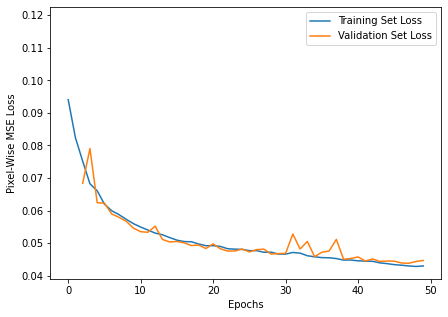

In [14]:
plt.figure(figsize=(7,5))
plt.plot(range(50), train_losses[:50], label = "Training Set Loss")
plt.plot(range(50), val_losses[:50], label = "Validation Set Loss")
plt.xlabel("Epochs")
plt.ylabel("Pixel-Wise MSE Loss")
plt.legend()


# sample output

In [23]:
encoding[0]

tensor([-1.0707e+00,  6.8637e-01, -4.3635e-01, -2.4899e-01, -6.5432e-01,
         1.2243e+00, -1.1758e-01, -1.5415e+00, -6.2352e-01,  4.7309e-03,
        -6.0123e-01, -1.8808e-01,  4.7922e-01, -3.5254e-01, -8.1944e-01,
         1.3900e+00,  6.1500e-01, -1.2868e-01,  5.8023e-01,  5.9471e-01,
         4.2415e-02,  3.5459e-01,  6.4813e-01, -1.8032e-01,  9.5277e-01,
        -8.8680e-01,  1.0039e+00, -9.2430e-01, -4.7902e-01, -4.9920e-01,
         6.3510e-02, -3.5950e-01, -3.0889e-01,  1.2119e-01,  6.9211e-01,
        -8.7633e-01,  4.0917e-01, -9.1570e-01, -1.0681e+00,  9.7704e-04,
        -4.0873e-01,  1.1186e+00,  7.3181e-01,  4.1016e-01,  5.8567e-01,
         3.3514e-03, -1.0421e-01,  3.9569e-01,  4.4314e-01, -6.5152e-01,
         2.4270e-01, -4.1118e-01,  1.8007e-01, -3.4089e-01, -7.0657e-01,
         2.9292e-01, -1.0114e+00, -5.5284e-01, -2.3604e-01, -2.3534e-01,
         3.9640e-01,  6.4541e-01, -1.0447e+00,  1.0020e+00, -1.7913e-01,
        -1.6063e-01, -6.9343e-01, -2.7099e-01, -7.5

In [16]:


val_dataloader = get_dataloader('5k', 128, 'test')

out = None


with torch.no_grad():
    g, c, gt = iter(val_dataloader).next()
    g = g.to(device)
    c = c.to(device)
    gt = gt.to(device)
    # g_lab = rgb_to_lab(g)
    # c_lab = rgb_to_lab(c)

    out, encoding, _ = colornet(g, gt=gt)
    # out_lab = rgb_to_lab(out)


# final_pred = torch.zeros(g.shape).to(device)
# final_pred[:, 0, :, :] = g_lab[:, 0, :, :]
# final_pred[:, 1:, :, :] = out_lab[:, 1:, :, :]

# final_pred = lab_to_rgb(final_pred)


for i in range(16):
    fig, ax = plt.subplots(1,3, figsize=(10,30))
    ax[0].imshow(g[i].detach().cpu().numpy().transpose(1,2,0))
    
    ax[1].imshow(out[i].detach().cpu().numpy().transpose(1,2,0))
    ax[1].axis("off")
    ax[2].imshow(c[i].detach().cpu().numpy().transpose(1,2,0))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

final_pred = torch.zeros(g.shape).to(device)
final_pred[:, 0, :, :] = g_lab[:, 0, :, :]
final_pred[:, 1:, :, :] = out_lab[:, 1:, :, :]

final_pred = lab_to_rgb(final_pred)


In [ ]:
out

torch.Size([32, 3, 128, 128])

In [ ]:
for i in range(16):
    fig, ax = plt.subplots(1,4, figsize=(10,40))
    ax[0].imshow(g[i].detach().cpu().numpy().transpose(1,2,0))
    ax[1].imshow(final_pred[i].detach().cpu().numpy().transpose(1,2,0))
    ax[2].imshow(out[i].detach().cpu().numpy().transpose(1,2,0))
    ax[3].imshow(c[i].detach().cpu().numpy().transpose(1,2,0))

Output hidden; open in https://colab.research.google.com to view.